In [1]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from functools import partial
import networkx as nx
from collections import defaultdict
# penny
import pennylane as qml
from pennylane.transforms import *
# self-developed
from gate_opt_utils import *
from penny_qiskit_utils import *
from penny_to_graph_20 import Penny_to_Graph


In [72]:
[ds] = qml.data.load("ketgpt")

In [73]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     13
num_gate     199
num_1q_gate  116
num_2q_gate   19
unitary       64
depth         66
None


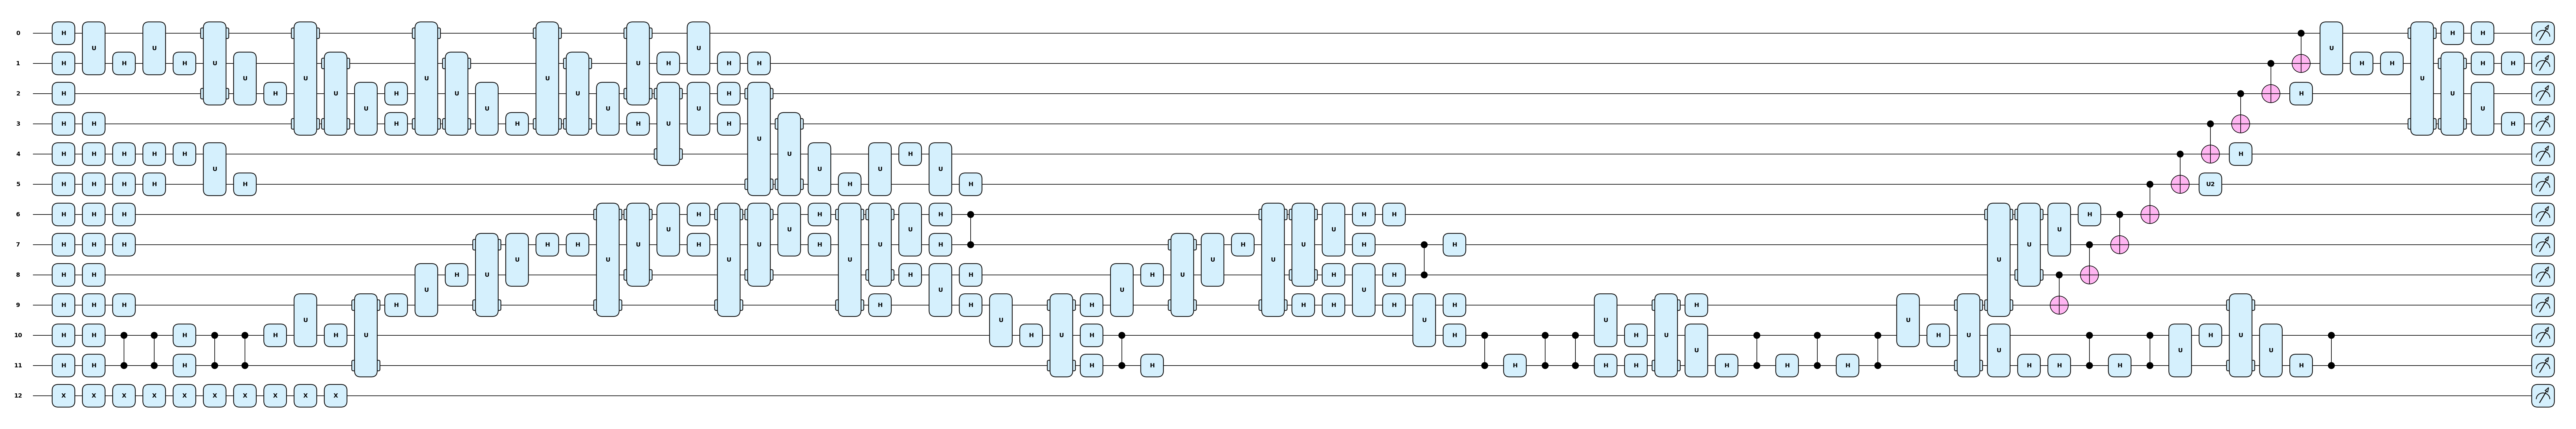

In [4]:
fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

In [5]:
circuit_info = extract_info_from_qnode(circuit)
pg_main = Penny_to_Graph(circuit)
G_main = pg_main.G
pos_main = pg_main.pos
node_colors_main = pg_main.node_colors

1. Level 2 optimization

In [6]:
q1 = ['Hadamard', 'PauliX', 'RY', 'U1', 'U2']
q2 = ['CNOT', 'CZ']
# circuit_info_q1 = circuit_info.copy()
circuit_info_q2 = circuit_info.copy()

for idx, dic in enumerate(circuit_info):
    if dic['name'] in q1:
        circuit_info_q2[idx] = {'name': 'QubitUnitary', 'wires': dic['wires'], 'params': [np.eye(2)]}

=== submodule to find a pair of 2q gates which cancle out

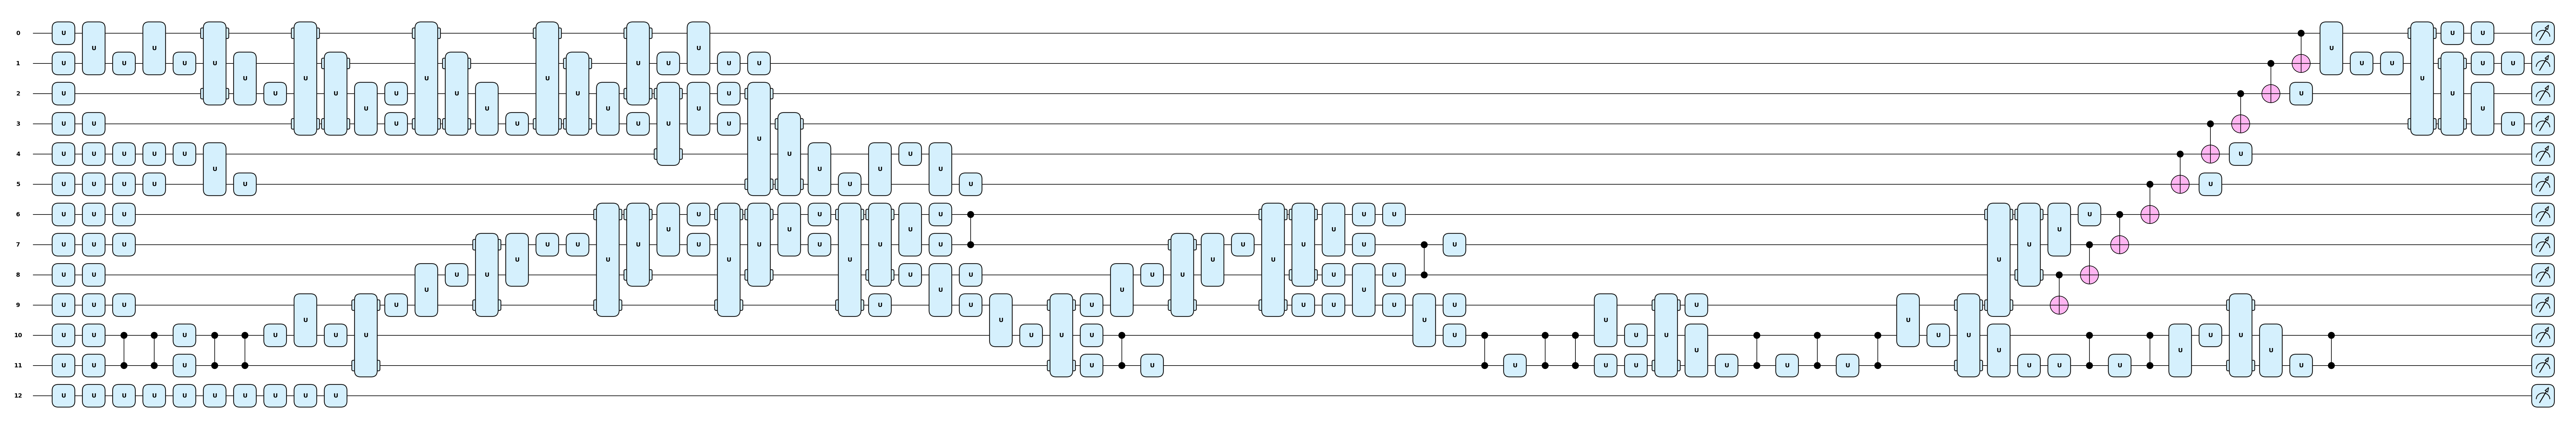

In [7]:
qnode_q2 = info_to_qnode(circuit_info_q2)
fig, axs = qml.draw_mpl(qnode_q2, style='pennylane')()
plt.show()

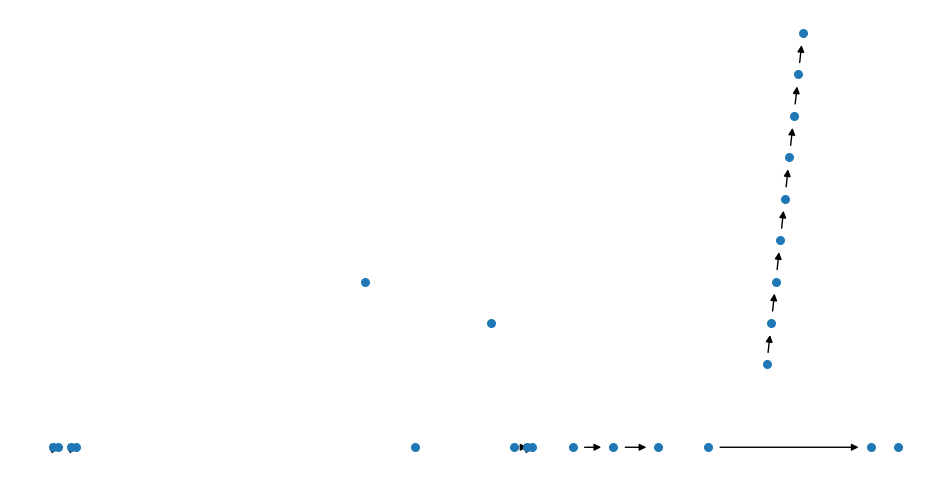

In [8]:
sub_pg = Penny_to_Graph(qnode_q2)
G = sub_pg.G
pos = sub_pg.pos
node_colors = sub_pg.node_colors

nodes_to_remove = [n for n, attr in G.nodes(data=True) if attr.get('label') in ('QubitUnitary')]
G_copy = G.copy()
G_copy.remove_nodes_from(nodes_to_remove)
pos = {n: pos[n] for n in G_copy.nodes if n in pos}
node_colors = [node_colors[list(G_copy.nodes).index(n)] for n in G_copy.nodes]

_, ax = plt.subplots(figsize=(12, 6))
nx.draw_networkx_nodes(G_copy, pos, node_size=30, ax=ax) # node_color=node_colors, 
edge_counts = defaultdict(int)
for u, v, k, d in G_copy.edges(keys=True, data=True):
    pair = (u, v)
    edge_counts[pair] += 1
    count = edge_counts[pair]
    rad = 0 if count == 1 else 0.2 * ((-1) ** count)
    nx.draw_networkx_edges(G_copy, pos, edgelist=[(u, v)],
                        connectionstyle=f'arc3,rad={rad}', ax=ax, arrows=True)
ax.axis('off')
plt.show() # colors are wrongly assigned

In [9]:
G_copy.edges() # notice the double edges

OutMultiEdgeDataView([('CZ_15', 'CZ_16'), ('CZ_15', 'CZ_16'), ('CZ_19', 'CZ_20'), ('CZ_19', 'CZ_20'), ('CZ_117', 'CZ_120'), ('CZ_120', 'CZ_121'), ('CZ_120', 'CZ_121'), ('CZ_130', 'CZ_139'), ('CZ_139', 'CZ_149'), ('CZ_160', 'CZ_196'), ('CNOT_173', 'CNOT_174'), ('CNOT_174', 'CNOT_175'), ('CNOT_175', 'CNOT_176'), ('CNOT_176', 'CNOT_177'), ('CNOT_177', 'CNOT_178'), ('CNOT_178', 'CNOT_179'), ('CNOT_179', 'CNOT_180'), ('CNOT_180', 'CNOT_181')])

In [10]:
edge_counts = defaultdict(int)
for u, v, _ in G_copy.edges(keys=True):
    edge_counts[(u, v)] += 1
multi_edge_pairs = [pair for pair, count in edge_counts.items() if count >= 2]
node_to_remove = np.array(multi_edge_pairs).flatten()
node_to_remove

array(['CZ_15', 'CZ_16', 'CZ_19', 'CZ_20', 'CZ_120', 'CZ_121'],
      dtype='<U6')

In [11]:
idx_to_remove = [i.split('_')[1] for i in node_to_remove]
idx_to_remove

['15', '16', '19', '20', '120', '121']

2. remove the nodes from G

In [12]:
sorted(idx_to_remove)

['120', '121', '15', '16', '19', '20']

In [58]:
circuit_info = extract_info_from_qnode(circuit)
idx_to_remove = [int(i) for i in idx_to_remove]

for i in sorted(idx_to_remove, reverse=True): # descending order
    print(circuit_info[i])
    del circuit_info[i]
    del ds.circuits[seed][i]
    
circuit_info

{'name': 'CZ', 'wires': [10, 11], 'params': []}
{'name': 'CZ', 'wires': [10, 11], 'params': []}
{'name': 'CZ', 'wires': [10, 11], 'params': []}
{'name': 'CZ', 'wires': [10, 11], 'params': []}
{'name': 'CZ', 'wires': [10, 11], 'params': []}
{'name': 'CZ', 'wires': [10, 11], 'params': []}


[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []},
 {'name': 'Hadamard', 'wires': [3], 'params': []},
 {'name': 'Hadamard', 'wires': [4], 'params': []},
 {'name': 'Hadamard', 'wires': [5], 'params': []},
 {'name': 'Hadamard', 'wires': [6], 'params': []},
 {'name': 'Hadamard', 'wires': [7], 'params': []},
 {'name': 'Hadamard', 'wires': [8], 'params': []},
 {'name': 'Hadamard', 'wires': [9], 'params': []},
 {'name': 'Hadamard', 'wires': [10], 'params': []},
 {'name': 'Hadamard', 'wires': [9], 'params': []},
 {'name': 'Hadamard', 'wires': [10], 'params': []},
 {'name': 'Hadamard', 'wires': [11], 'params': []},
 {'name': 'Hadamard', 'wires': [11], 'params': []},
 {'name': 'Hadamard', 'wires': [10], 'params': []},
 {'name': 'Hadamard', 'wires': [11], 'params': []},
 {'name': 'QubitUnitary',
  'wires': [1, 0],
  'params': [[[(1+0j), 0j, 0j, 0j],
    [0j, (1+0j), 0j, 0j],
    [0j, 0j, (1+0j),

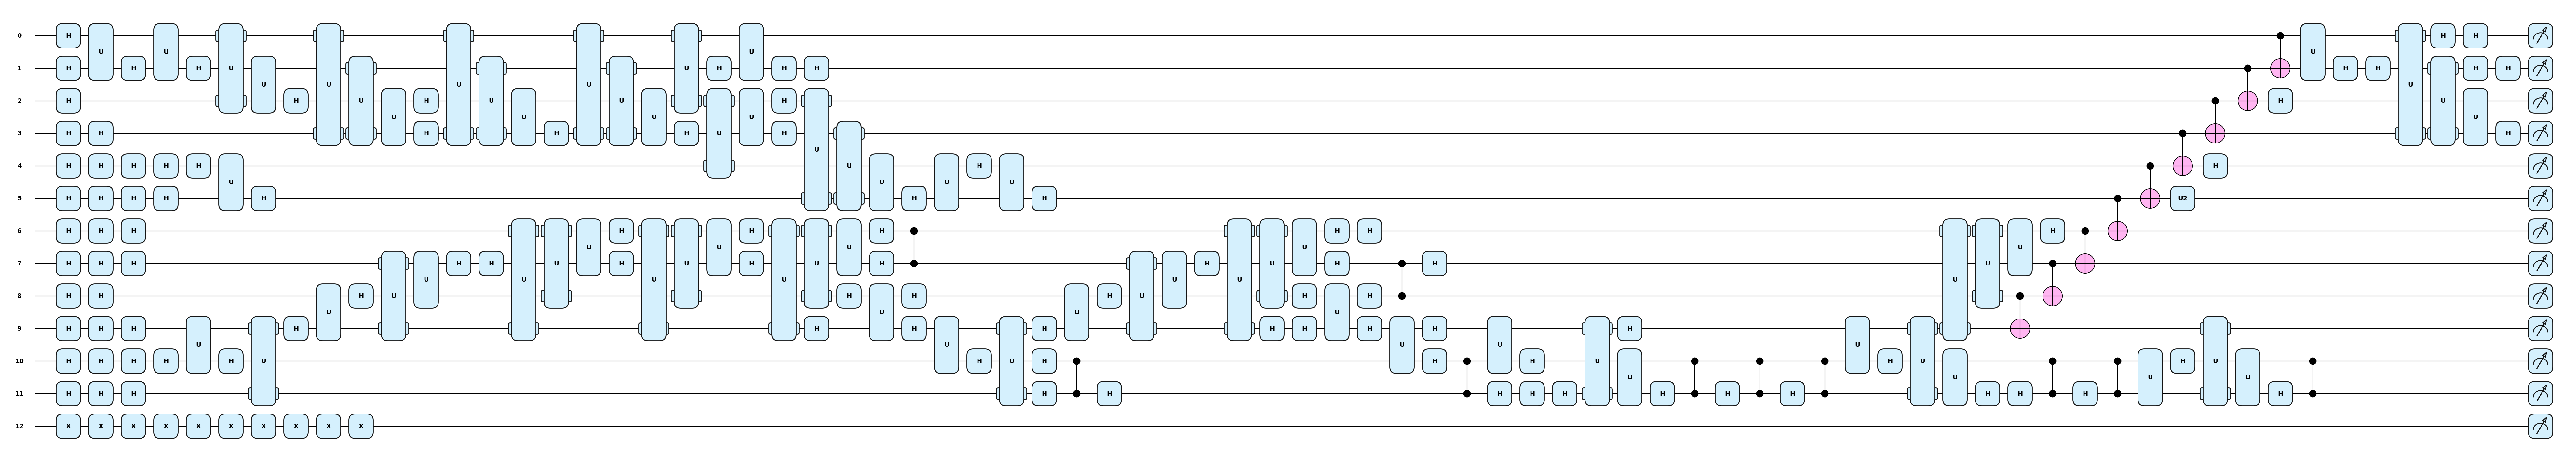

In [63]:
qnode_q1 = info_to_qnode(circuit_info)
fig, axs = qml.draw_mpl(qnode_q1, style='pennylane')()
plt.show()

In [ ]:
circuit_info_q1 = extract_info_from_qnode(qnode_q1) # same with circuit_info
for idx, dic in enumerate(circuit_info_q1):
    if dic['name'] in q2:
        circuit_info_q1[idx] = {'name': 'QubitUnitary', 'wires': dic['wires'], 'params': [np.eye(4)]}

qnode_q1 = info_to_qnode(circuit_info_q1)

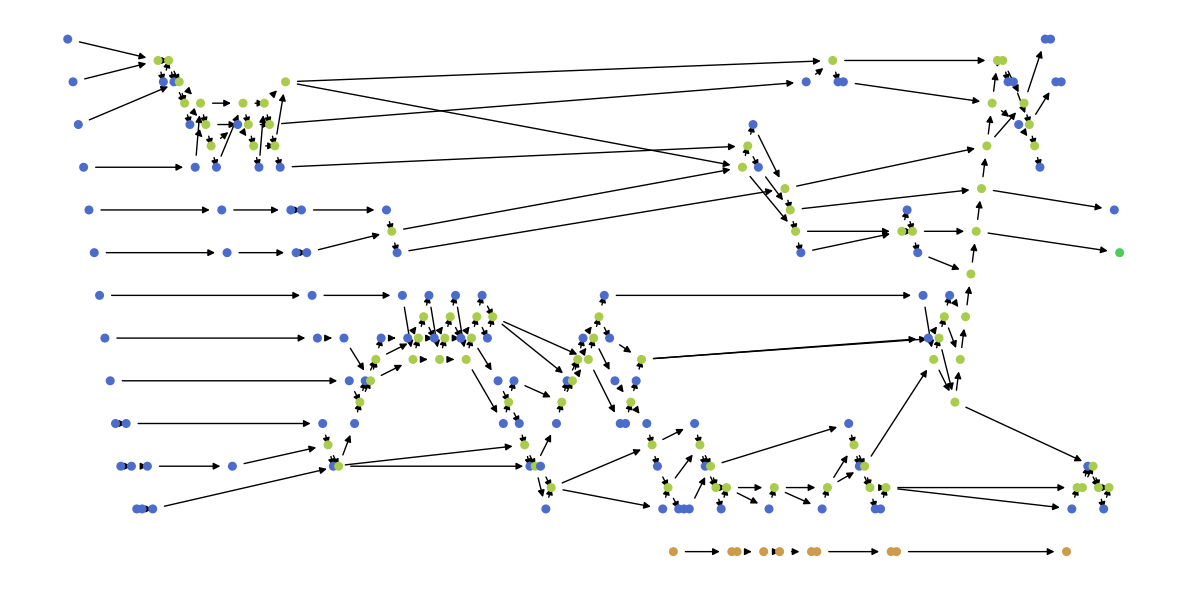

In [65]:
my_pg = Penny_to_Graph(qnode_q1)
G = my_pg.G
my_pg.show_graph(my_pg.G)

In [ ]:
G, communities = qc_com_detection(G, barriers=['QubitUnitary'])

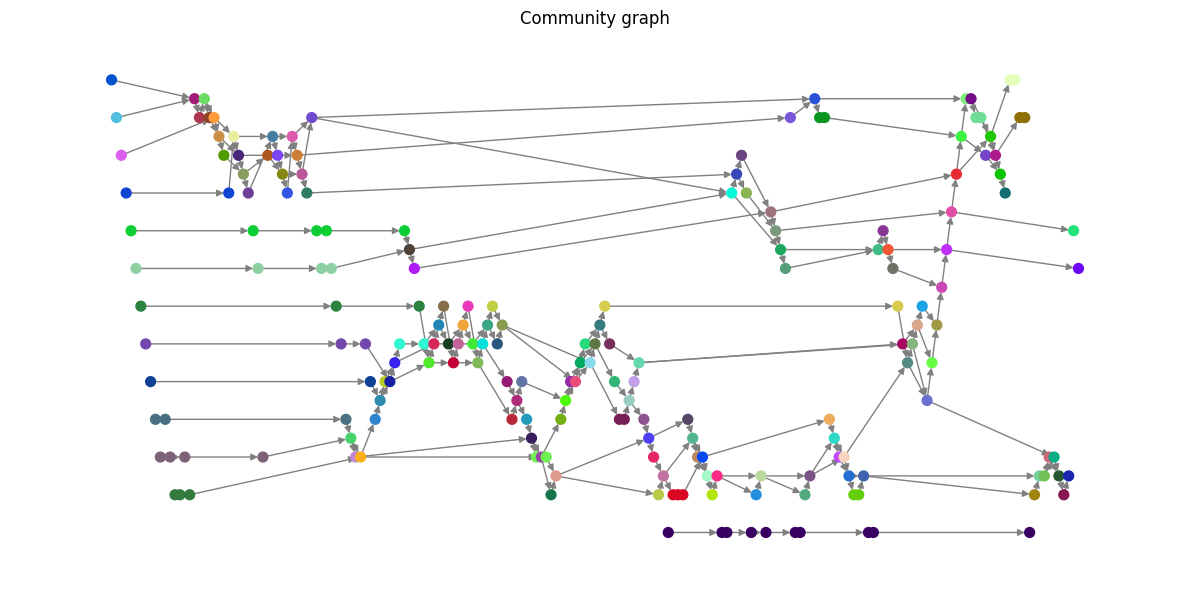

In [ ]:
def color_generator(n):
    random.seed(42)
    colors = []
    for _ in range(n):
        hex_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(hex_color)
    return colors

palette = color_generator(len(communities))

# Step 2: Assign colors to communities
node_color_map = {}
for i, community in enumerate(communities):
    color = palette[i % len(palette)]
    for node in community:
        node_color_map[node] = color

# Step 3: Build node_colors list
pos = my_pg.pos
node_colors = [node_color_map.get(node, '#999999') for node in G.nodes]

# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=8, edge_color='gray', ax=ax)
plt.title('Community graph')
plt.tight_layout()
plt.show()

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         67


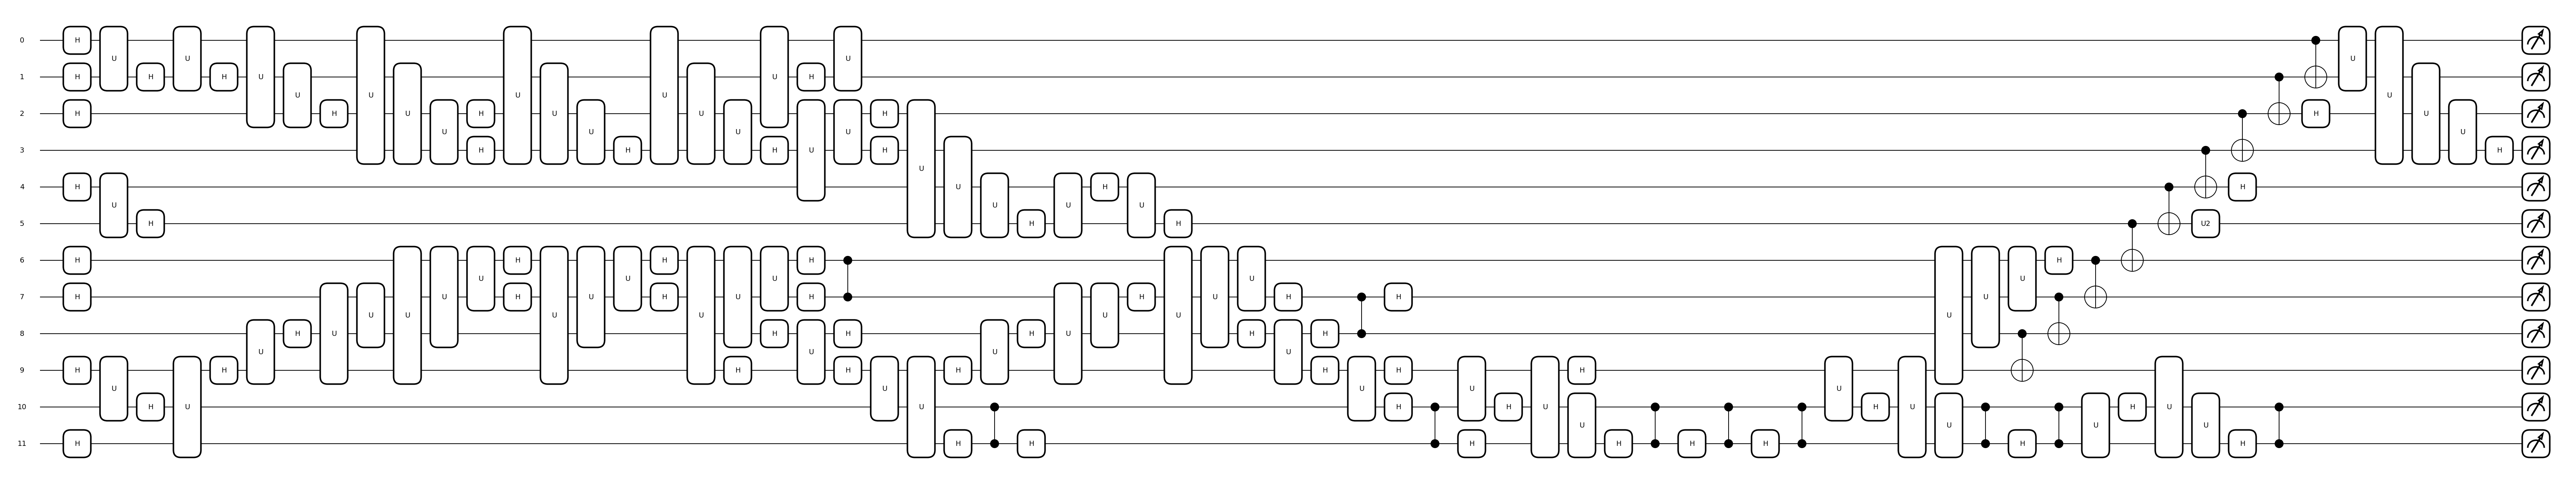

In [ ]:
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
circuit_lev_1 = level_1_sythesis(effective_u_dic)
summary_penny(circuit_lev_1)
qml.draw_mpl(circuit_lev_1)()
plt.show() 

=== end of the process

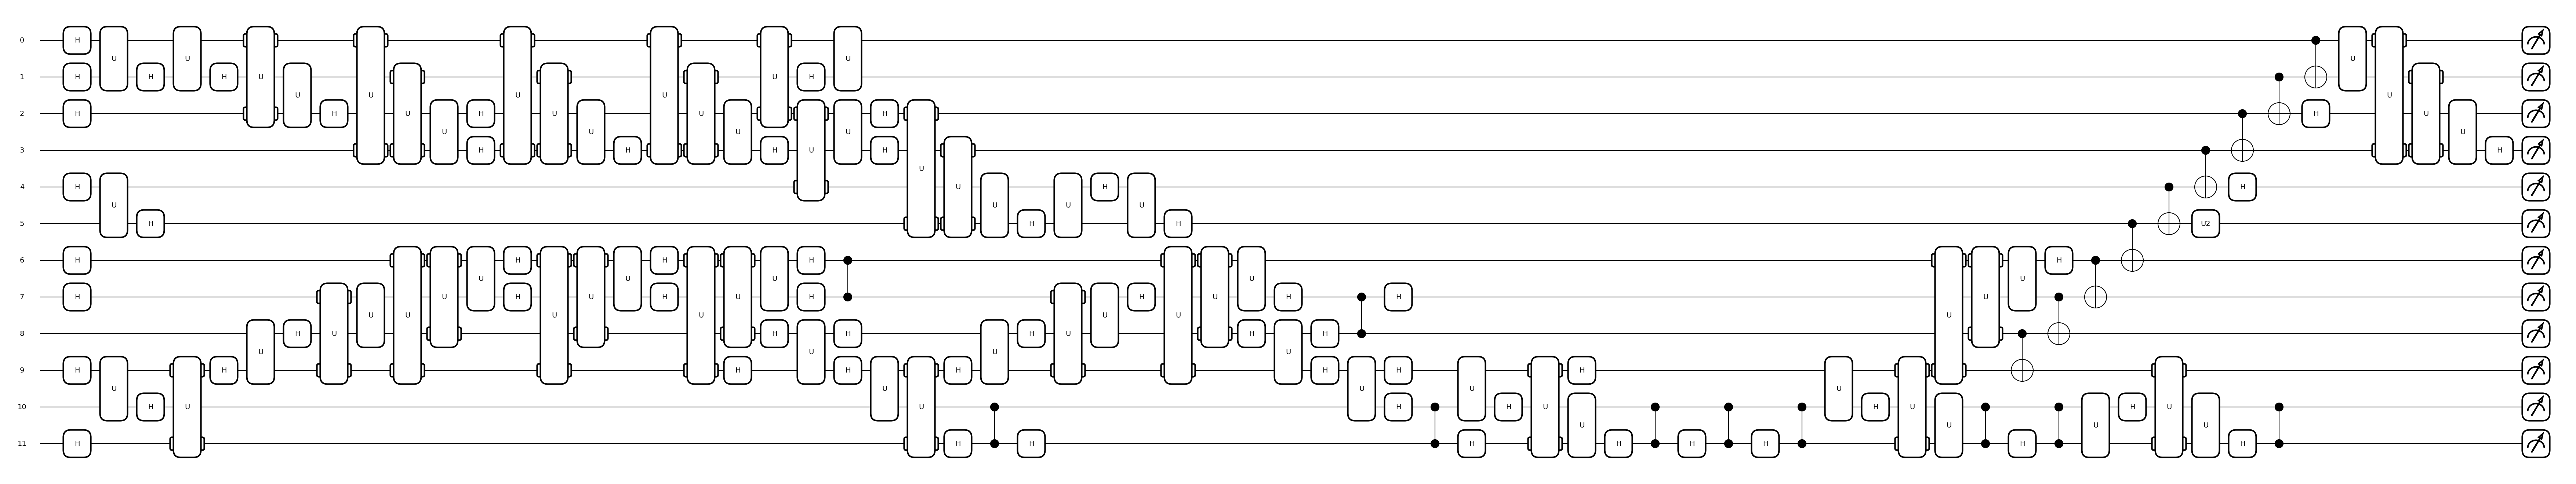

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         59
None


In [74]:
@compile
@qml.qnode(qml.device('default.qubit'))
def circuit(): 
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

qml.draw_mpl(circuit)()
plt.show() 

print(summary_penny(circuit))